### Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [5]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Creating DFs

In [6]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    './Anno/list_attr_cloth.txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    './Anno/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')

In [7]:
#create list of column names to keep for training
# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts, 5 = Style
list_attr_names = ['image_name']+attributes[(attributes['attribute_type']==1)]['attribute_name'].tolist()
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()
training_df.reset_index(drop=True, inplace=True)

In [8]:
#removing images from DF with no label
training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
training_df = training_df[training_df['max'].isin([True])].copy()
training_df.drop('max', axis=1, inplace=True)

In [ ]:
test_df = cleaned_df[cleaned_df['evaluation_status'].isin(['test'])][['image_name','category_name']].copy()
training_df['category_name'].value_counts()
test_df['category_name'].value_counts().plot()

In [9]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df

#.sort_values(by='Count')

## Baseline Model (No Data Cleaning)

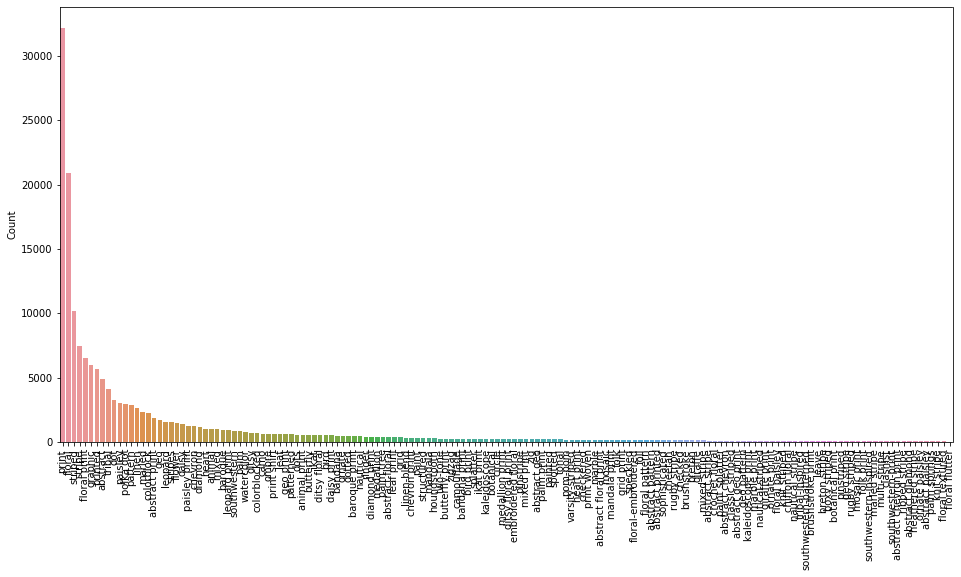

In [10]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

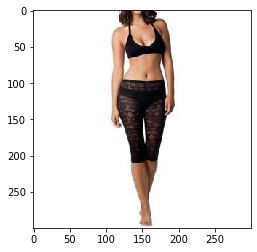

In [11]:
from matplotlib import image

# load the image
data = image.imread('./Img/img/Side-Cutout_Capri_Leggings/img_00000028.jpg')

plt.imshow(data)
plt.show()

In [12]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

In [13]:
# take all the columns after the first "image_name" col
label_column_names = training_df.columns.tolist()[1:]

img_base_path = Path("./Img/")
data = ImageDataBunch.from_df(img_base_path, training_df, ds_tfms=get_transforms(), size=150, label_col=label_column_names)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (76848 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
sophisticated,print,floral,camo,printed
Path: Img;

Valid: LabelList (19212 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
floral,stripe,paisley,linen,ornate
Path: Img;

Test: None

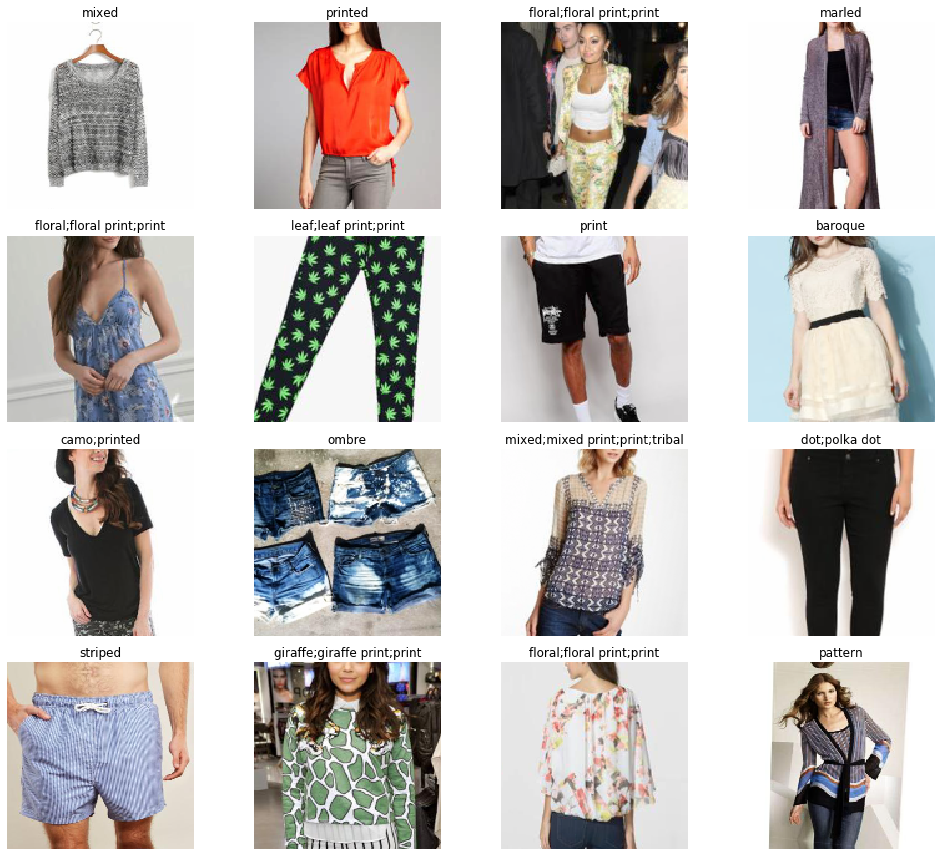

In [14]:
data.show_batch(rows=4, figsize=(14,12))

In [15]:
print(data.classes)
len(data.classes),data.c


['abstract', 'abstract chevron', 'abstract chevron print', 'abstract diamond', 'abstract floral', 'abstract floral print', 'abstract geo', 'abstract geo print', 'abstract paisley', 'abstract pattern', 'abstract print', 'abstract printed', 'abstract stripe', 'animal', 'animal print', 'bandana', 'bandana print', 'baroque', 'baroque print', 'bird', 'bird print', 'botanical', 'botanical print', 'boxy striped', 'breton', 'breton stripe', 'brushstroke', 'brushstroke print', 'butterfly', 'butterfly print', 'camo', 'camouflage', 'checked', 'checkered', 'cheetah', 'chevron', 'chevron print', 'chiffon floral', 'circle', 'clashist', 'classic striped', 'colorblock', 'colorblocked', 'crochet floral', 'daisy', 'daisy print', 'diamond', 'diamond print', 'ditsy', 'ditsy floral', 'ditsy floral print', 'dot', 'dots', 'dotted', 'embroidered floral', 'floral', 'floral flutter', 'floral paisley', 'floral pattern', 'floral print', 'floral textured', 'floral-embroidered', 'flower', 'foil', 'folk', 'folk prin

(156, 156)

In [16]:
# Iteration 1: [acc, fbeta] metrics
# acc_03 = partial(accuracy_thresh, thresh=0.3)
# learn = cnn_learner(data, models.resnet50, metrics=[acc_03, f_score], callback_fns=ShowGraph)

learn = cnn_learner(data, models.resnet50, metrics=fbeta, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,fbeta,time
0,0.039772,0.038096,0.381744,06:36
1,0.037018,0.035677,0.420414,06:37
2,0.036046,0.034849,0.438977,06:30
3,0.035192,0.034275,0.456324,06:30
4,0.034657,0.033940,0.461480,06:35
5,0.033696,0.033635,0.466482,06:39
6,0.033630,0.033478,0.470211,06:38
7,0.033479,0.033501,0.469120,06:31


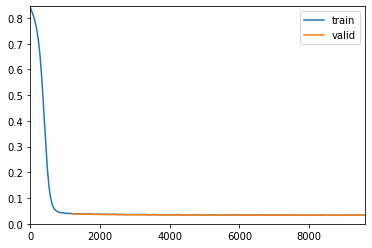

In [17]:
learn.fit_one_cycle(8)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


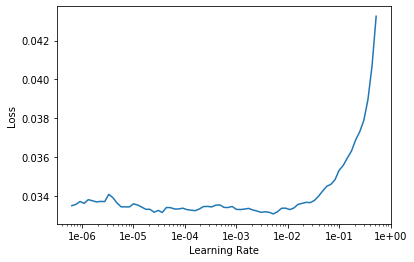

In [19]:
learn.recorder.plot()

epoch,train_loss,valid_loss,fbeta,time
0,0.033225,0.033469,0.468992,06:33
1,0.033126,0.033438,0.471210,06:36
2,0.033768,0.033439,0.470367,06:33
3,0.033268,0.033454,0.469704,06:32


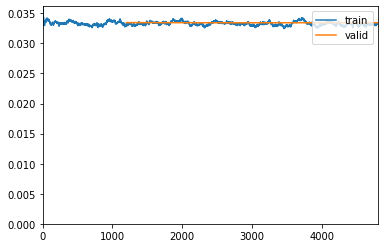

In [20]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,fbeta,time
0,0.034048,0.033295,0.473328,08:15
1,0.032626,0.033058,0.476251,08:15
2,0.032282,0.032924,0.477089,08:13
3,0.032051,0.032919,0.480290,08:13


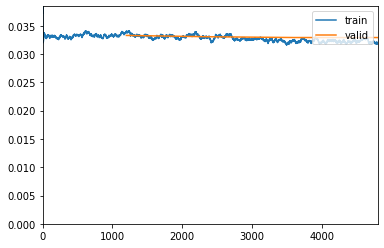

In [21]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

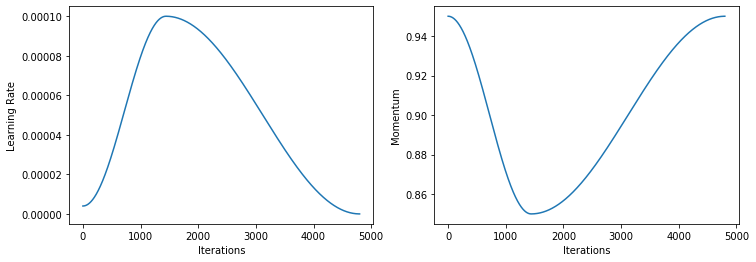

In [22]:
learn.recorder.plot_lr(show_moms=True)

In [23]:
learn.save('texture-resnet50-size150-fr12-unfr4', return_path=True)

WindowsPath('Img/models/texture-resnet50-size150-fr12-unfr4.pth')

In [24]:
learn.export('texture-resnet50-size150-fr12-unfr4.pkl')

In [25]:
learn = load_learner('Img/','texture-resnet50-size150-fr12-unfr4.pkl')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_multi_top_losses(6, figsize=(8,6))

## utilising test data

In [ ]:
img_base_path = Path("Img/")
testdata = ImageDataBunch.from_df(img_base_path, test_df, ds_tfms=get_transforms(), size=224)
testdata.normalize(imagenet_stats)


learn.data = testdata

output, target = learn.get_preds(ds_type=DatasetType.Train)
top_k_accuracy(output, target, topk=(3,))

output, target = learn.get_preds(ds_type=DatasetType.Train)
top_k_accuracy(output, target, topk=(5,))